# Detection of interictal periods in EEG signals using machine learning

## Processing of databases

## Prepare the environment

### Install requirements

In [ ]:
!pip install -r ../requirements.txt

### Global variables

In [3]:
PATH_DATASET = "../datasets"
PATH_SCRIPTS = "../scripts"
PATH_RESULTS = "../results"

### Import libraries

import sys
sys.path.append(PATH_SCRIPTS)
from load_data import extract_data

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy as shannon_entropy
from scipy.stats import skew, kurtosis
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append(PATH_SCRIPTS)
from load_data import extract_data

## Loading datasets

In [3]:
raw_path = PATH_DATASET +"/Raw_data.zip"

dataset= extract_data(raw_path)
for key, value in dataset.items():
    print(f"{key}: {len(value)}")

F: 100
N: 100
O: 100
S: 100
Z: 100
interictal: 50
preictal: 50
ictal: 50


## calculation of main characteristics for each signal
Activity, mobility, complexity, energy, entropy, standard deviation, kurtosis, zero crossings, label calculation

===================================================================

In [6]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113660 sha256=ec5496033206bea2197c3bca6f7c81d93ceedb97a609c082f453c43f7f71c422
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [10]:
import pycatch22
import numpy as np
import pandas as pd
from tqdm import tqdm

In [24]:
all_features = []
all_labels = []


true_events = ["F", "N", "interictal"]

for key, signals in dataset.items():
    for signal in tqdm(signals):
        results = pycatch22.catch22_all(signal)
        feature_row = dict(zip(results['names'], results['values']))
        feature_row['Label'] = 1 if key in true_events else 0


        all_features.append(feature_row)


# Crear el DataFrame completo
features_df = pd.DataFrame(all_features)

100%|██████████| 50/50 [00:00<00:00, 129.98it/s]


In [25]:
print(features_df.head)

<bound method NDFrame.head of      DN_HistogramMode_5  DN_HistogramMode_10  CO_f1ecac  CO_FirstMin_ac  \
0              0.032470             0.359067  14.290139              62   
1              0.358236            -0.076996  25.310069              67   
2             -0.152628             0.148900  15.135815              55   
3             -0.403317            -0.068715   9.238169              33   
4             -0.444262            -0.031429   7.763797              35   
..                  ...                  ...        ...             ...   
645            0.105634            -0.255798   9.349639              44   
646            0.901130             0.683295  15.013255              43   
647           -0.686353            -0.438247  10.556441              34   
648            0.283932             0.507770  14.903922              41   
649            0.381691             0.031973   9.603532              38   

     CO_HistogramAMI_even_2_5  CO_trev_1_num  MD_hrv_classic_pnn40  \

In [26]:
corr_matrix = features_df.corr().round(3)


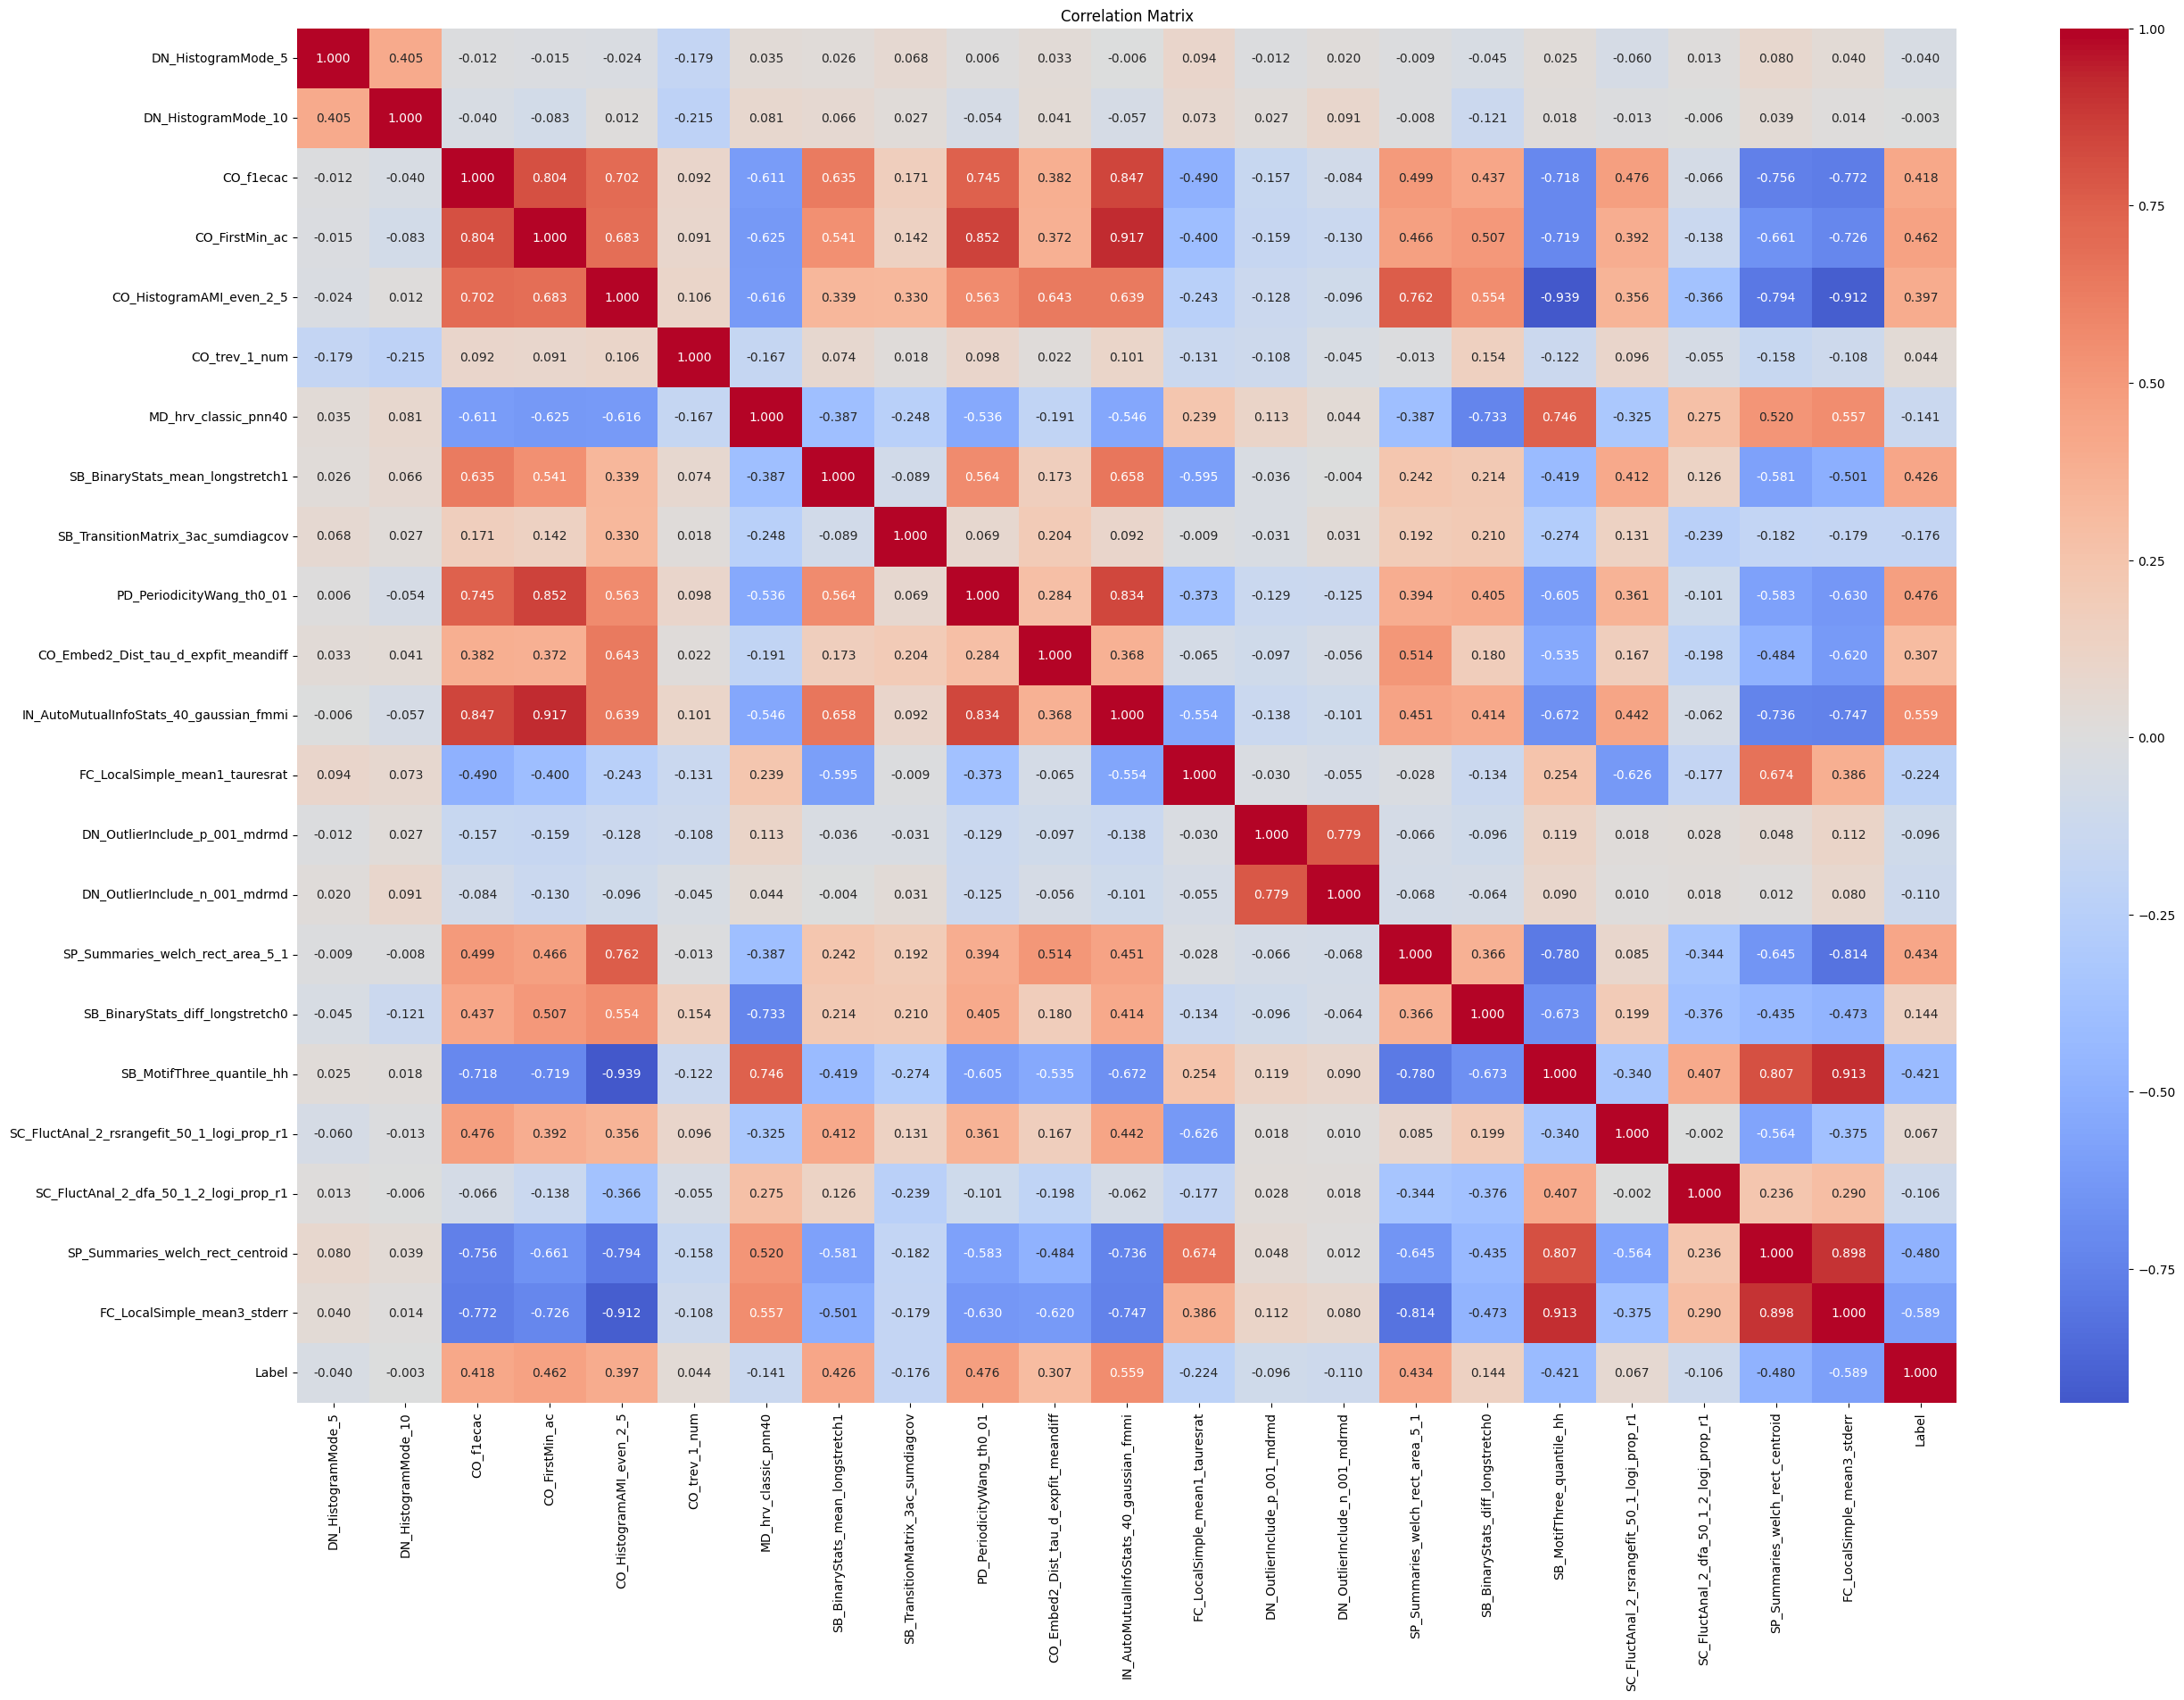

In [27]:
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

DN_HistogramMode_5                            -0.040
DN_HistogramMode_10                           -0.003
CO_f1ecac                                      0.418
CO_FirstMin_ac                                 0.462
CO_HistogramAMI_even_2_5                       0.397
CO_trev_1_num                                  0.044
MD_hrv_classic_pnn40                          -0.141
SB_BinaryStats_mean_longstretch1               0.426
SB_TransitionMatrix_3ac_sumdiagcov            -0.176
PD_PeriodicityWang_th0_01                      0.476
CO_Embed2_Dist_tau_d_expfit_meandiff           0.307
IN_AutoMutualInfoStats_40_gaussian_fmmi        0.559
FC_LocalSimple_mean1_tauresrat                -0.224
DN_OutlierInclude_p_001_mdrmd                 -0.096
DN_OutlierInclude_n_001_mdrmd                 -0.110
SP_Summaries_welch_rect_area_5_1               0.434
SB_BinaryStats_diff_longstretch0               0.144
SB_MotifThree_quantile_hh                     -0.421
SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1   

/tmp/ipython-input-29-3352653994.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_corr.values, y=label_corr.index, palette="viridis")


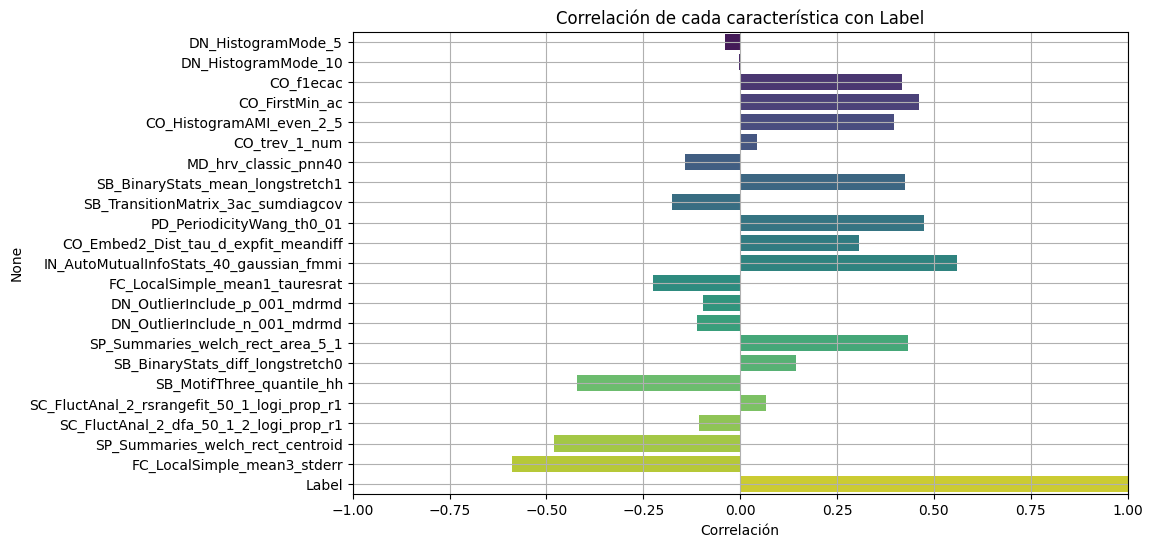

In [29]:
label_corr = features_df.corr()['Label']
print(label_corr.round(3))
plt.figure(figsize=(10, 6))
sns.barplot(x=label_corr.values, y=label_corr.index, palette="viridis")
plt.title("Correlación de cada característica con Label")
plt.xlabel("Correlación")
plt.xlim(-1, 1)
plt.grid(True)
plt.show()

In [30]:
threshold = 0.2
selected_features = label_corr[abs(label_corr) >= threshold].index.tolist()
filtered_df = features_df[selected_features]
cols = [col for col in filtered_df.columns if col != 'Label'] + ['Label']
filtered_df = filtered_df[cols]

In [31]:
print (filtered_df)

     CO_f1ecac  CO_FirstMin_ac  CO_HistogramAMI_even_2_5  \
0    14.290139              62                  0.586695   
1    25.310069              67                  0.609680   
2    15.135815              55                  0.594365   
3     9.238169              33                  0.567593   
4     7.763797              35                  0.402087   
..         ...             ...                       ...   
645   9.349639              44                  0.607148   
646  15.013255              43                  0.773230   
647  10.556441              34                  0.637685   
648  14.903922              41                  0.851138   
649   9.603532              38                  0.567674   

     SB_BinaryStats_mean_longstretch1  PD_PeriodicityWang_th0_01  \
0                                93.0                        250   
1                               178.0                        314   
2                                78.0                        106   
3      

In [ ]:
filtered_df.to_csv(PATH_RESULTS+"/features/EEG_features_pycatch22.csv",sep=';', index=False)